In [1]:
!pip install --upgrade pip
!pip install --upgrade jupyter
!pip install --upgrade ipywidgets
!pip install tensorflow
!pip install pyrouge
!pip install -q rouge-score nltk
!pip install nltk
!pip install wurlitzer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.7
    Uninstalling widgetsnbextension-3.6.7:
      Successfully uninstalled widgetsnbextension-3.6.7
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found e

In [2]:
import os
import gensim as gs
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import nltk
import tensorflow as tf
import keras
import tensorflow.keras.backend as K
K.set_learning_phase(1)
from nltk.tokenize import word_tokenize as wt
from nltk.tokenize import sent_tokenize as st
from numpy.random import seed
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split as tts
from collections import Counter
from pyrouge import Rouge155
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import initializers
from keras.optimizers import RMSprop
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Add, TimeDistributed, Flatten, Multiply, Activation, Permute, Lambda, Dot, Softmax, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

2024-08-01 18:21:43.670047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 18:21:43.670171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 18:21:43.790726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [3]:
df_train = pd.read_csv("/kaggle/input/pubmed-dataset/train_dataset.csv")
df_test = pd.read_csv("/kaggle/input/pubmed-dataset/test_dataset.csv")
df_val = pd.read_csv("/kaggle/input/pubmed-dataset/validation_dataset.csv")

In [4]:
# Ensure 'article' and 'abstract' columns are treated as strings
df_train['article'] = df_train['article'].astype(str)
df_train['abstract'] = df_train['abstract'].astype(str)

df_test['article'] = df_test['article'].astype(str)
df_test['abstract'] = df_test['abstract'].astype(str)

df_val['article'] = df_val['article'].astype(str)
df_val['abstract'] = df_val['abstract'].astype(str)

In [5]:
print(len(df_train['article']), len(df_train['abstract']))
print(len(df_test['article']), len(df_test['abstract']))
print(len(df_val['article']), len(df_val['abstract']))

119924 119924
6658 6658
6552 6552


In [6]:
df = pd.concat([df_train, df_test, df_val], ignore_index=True)

In [7]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
data = df.head(1000)

In [9]:
print(len(data))

1000


In [10]:
# data = df.sample(n=500, random_state=42)
# data.sample(frac=0.1, random_state=42)

In [11]:
total_emb_size = 300
max_corp = 5000

In [12]:
def createCorpus(t):
    corpus = []
    all_sent = []
    for k in t:
        for p in t[k]:
            corpus.append(st(p))
    for sent in range(len(corpus)):
        for k in corpus[sent]:
            all_sent.append(k)
    for m in range(len(all_sent)):
        all_sent[m] = wt(all_sent[m])
    
    all_words=[]
    for sent in all_sent:
        hold=[]
        for word in sent:
            hold.append(word.lower())
        all_words.append(hold)
    return all_words

In [13]:
def word2vecmodel(corpus):
    emb_size = total_emb_size
    model_type={"skip_gram":1,"CBOW":0}
    window=10
    workers=4
    min_count=4
    batch_words=20
    epochs=25
    #include bigrams
    #bigramer = gs.models.Phrases(corpus)

    model=gs.models.Word2Vec(corpus,vector_size=emb_size,sg=model_type["skip_gram"],
                             compute_loss=True,window=window,min_count=min_count,workers=workers,
                             batch_words=batch_words)
        
    model.train(corpus,total_examples=len(corpus),epochs=epochs)
    model.save("%sWord2vec")
    print('\007')
    return model

In [14]:
def summonehot(corpus):
    allwords=[]
    annotated={}
    for sent in corpus:
        for word in wt(sent):
            allwords.append(word.lower())
    print(len(set(allwords)), "unique characters in corpus")
    
    #maxcorp=int(input("Enter desired number of vocabulary: "))
    max_corp=int(len(set(allwords))/1.1)
    wordcount = Counter(allwords).most_common(max_corp)
    allwords=[]
    
    for p in wordcount:
        allwords.append(p[0])  
        
    allwords=list(set(allwords))
    
    print(len(allwords), "unique characters in corpus after max corpus cut")
    
    #integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(allwords)
    
    #one hot
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    #make look up dict
    for k in range(len(onehot_encoded)): 
        inverted = label_encoder.inverse_transform([argmax(onehot_encoded[k, :])])[0].strip()
        annotated[inverted]=onehot_encoded[k]
    return label_encoder,onehot_encoded,annotated

In [15]:
def wordvecmatrix(model, data):
    IO_data = {"article": [], "abstract": []}
    for i, (article, abstract) in enumerate(zip(data["article"], data["abstract"])):
        art = []
        summ = []

        # Process article
        for word in wt(article.lower()):
            try:
                art.append(model.wv[word])
            except KeyError:
                continue  # Skip words not in the vocabulary

        # Process abstract
        for word in wt(abstract.lower()):
            try:
                summ.append(onehot[word])
            except KeyError:
                continue  # Skip words not in the onehot encoding

        IO_data["article"].append(art)
        IO_data["abstract"].append(summ)

        if (i + 1) % 100 == 0:
            print(f"Progress: {((i + 1) * 100) / len(data['article']):.2f}%")

    print('\007')  # Sound notification (optional)
    return IO_data

In [16]:
def cutoffSequences(data,artLen,sumlen):
    data2={"article":[],"abstract":[]}
    for k in range(len(data["article"])):
        if len(data["article"][k])<artLen or len(data["abstract"][k])<sumlen:
             pass
        else:
            data2["article"].append(data["article"][k][:artLen])
            data2["abstract"].append(data["abstract"][k][:sumlen])
    return data2

In [17]:
def max_len(data):
    lenk=[]
    for k in data:
        lenk.append(len(k))
    print("The minimum length is: ",min(lenk))
    print("The average length is: ",np.average(lenk))
    print("The max length is: ",max(lenk))
    return min(lenk),max(lenk)

In [18]:
"""reshape vectors for Gensim"""
def reshape(vec):
    return np.reshape(vec,(1,total_emb_size))

def addones(seq):
    return np.insert(seq, [0], [[0],], axis = 0)

def endseq(seq):
    pp=len(seq)
    return np.insert(seq, [pp], [[1],], axis = 0)

In [19]:
corpus = createCorpus(data)

label_encoder,onehot_encoded,onehot=summonehot(data["abstract"])

model=word2vecmodel(corpus)

model.get_latest_training_loss()

train_data = wordvecmatrix(model,data)

print(len(train_data["article"]), "training articles")

train_data=cutoffSequences(train_data,300,25)

16664 unique characters in corpus
15149 unique characters in corpus after max corpus cut


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Progress: 10.00%
Progress: 20.00%
Progress: 30.00%
Progress: 40.00%
Progress: 50.00%
Progress: 60.00%
Progress: 70.00%
Progress: 80.00%
Progress: 90.00%
Progress: 100.00%

1000 training articles


In [20]:
#seq length stats
max_len(train_data["article"])
max_len(train_data["abstract"])

train_data["abstract"]=np.array(train_data["abstract"])
train_data["article"]=np.array(train_data["article"])

print("abstract length: ",len(train_data["abstract"][0]))
print("article length: ",len(train_data["article"][0]))

The minimum length is:  300
The average length is:  300.0
The max length is:  300
The minimum length is:  25
The average length is:  25.0
The max length is:  25
abstract length:  25
article length:  300


In [21]:
#add start sequence
train_data["abstract"]=np.array(list(map(addones,train_data["abstract"])))

In [23]:
en_shape=np.shape(train_data["article"][0])
de_shape=np.shape(train_data["abstract"][0])

In [22]:
batch_size = 50
num_classes = 1
epochs = 20
hidden_units = total_emb_size
lr = 0.005
clip_norm = 2.0

In [24]:
def encoder_decoder(data):
    print('Encoder_Decoder LSTM')
   
    # Encoder
    encoder_inputs = Input(shape=en_shape)
    
    encoder_LSTM = LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True)
    encoder_LSTM_rev = LSTM(hidden_units, return_state=True, return_sequences=True, dropout=0.05, recurrent_dropout=0.05, go_backwards=True)
    
    encoder_outputs, state_h, state_c = encoder_LSTM(encoder_inputs)
    encoder_outputsR, state_hR, state_cR = encoder_LSTM_rev(encoder_inputs)
    
    state_hfinal = Add()([state_h, state_hR])
    state_cfinal = Add()([state_c, state_cR])
    encoder_outputs_final = Add()([encoder_outputs, encoder_outputsR])
    
    encoder_states = [state_hfinal, state_cfinal]
    
    # Decoder
    decoder_inputs = Input(shape=(None, de_shape[1]))
    decoder_LSTM = LSTM(hidden_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, return_state=True)
    decoder_outputs, _, _ = decoder_LSTM(decoder_inputs, initial_state=encoder_states)
    
    # Attention mechanism
    attention = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs_final])
    attention = Activation('softmax')(attention)
    context = Dot(axes=[2, 1])([attention, encoder_outputs_final])

    # Concatenate context with decoder outputs
    decoder_combined_context = Concatenate(axis=-1)([context, decoder_outputs])
 
    decoder_dense = Dense(de_shape[1], activation='softmax')
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
    print(model.summary())
    
    rmsprop = RMSprop(lr=lr, clipnorm=clip_norm)
    model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])
    
    x_train, x_test, y_train, y_test = tts(data["article"], data["abstract"], test_size=0.20)
    
    history = model.fit([x_train, y_train],
                        y=y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=([x_test, y_test], y_test))
    print(model.summary())
    
    # Inference mode
    encoder_model_inf = Model(encoder_inputs, encoder_states)
    
    decoder_state_input_H = Input(shape=(hidden_units,))
    decoder_state_input_C = Input(shape=(hidden_units,)) 
    decoder_state_inputs = [decoder_state_input_H, decoder_state_input_C]
    decoder_outputs, decoder_state_h, decoder_state_c = decoder_LSTM(decoder_inputs, initial_state=decoder_state_inputs)
    decoder_states = [decoder_state_h, decoder_state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    
    decoder_model_inf = Model([decoder_inputs] + decoder_state_inputs,
                              [decoder_outputs] + decoder_states)
    
    scores = model.evaluate([x_test, y_test], y_test, verbose=1)
    
    print('LSTM test scores:', scores)
    print('\007')
    print(model.summary())
    return model, encoder_model_inf, decoder_model_inf, history

In [25]:
def saveModels():
    trained_model.save("%sinit_model")
    encoder.save("%sencoder")
    decoder.save("%sdecoder")

In [26]:
trained_model,encoder,decoder,history = encoder_decoder(train_data)

Encoder_Decoder LSTM
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300)]           0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 300, 300),           721200    ['input_1[0][0]']             
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                                  
 lstm_1 (LSTM)               [(None, 300, 300),           721200    ['input_1[0][0]']             
                              (None, 300),                               

I0000 00:00:1722537123.221139     315 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 [==============================] - 41s 2s/step - loss: 8.9657 - accuracy: 0.0092 - val_loss: 8.3978 - val_accuracy: 0.0110
Epoch 2/20
16/16 [==============================] - 27s 2s/step - loss: 8.1824 - accuracy: 0.0094 - val_loss: 8.2924 - val_accuracy: 0.0110
Epoch 3/20
16/16 [==============================] - 27s 2s/step - loss: 8.0144 - accuracy: 0.0124 - val_loss: 8.3098 - val_accuracy: 0.0108
Epoch 4/20
16/16 [==============================] - 27s 2s/step - loss: 7.9411 - accuracy: 0.0116 - val_loss: 8.3188 - val_accuracy: 0.0084
Epoch 5/20
16/16 [==============================] - 27s 2s/step - loss: 7.8916 - accuracy: 0.0123 - val_loss: 8.3353 - val_accuracy: 0.0122
Epoch 6/20
16/16 [==============================] - 27s 2s/step - loss: 7.8430 - accuracy: 0.0130 - val_loss: 8.3341 - val_accuracy: 0.0100
Epoch 7/20
16/16 [==============================] - 27s 2s/step - loss: 7.7953 - accuracy: 0.0132 - val_loss: 8.3605 - val_accuracy: 0.0134
Epoch 8/20
16/16 [=============

In [27]:
def plot_training(history):
    print(history.history.keys())
    
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [28]:
def evaluate_summ(article_pos):
    # Check if data is a DataFrame or array
    if isinstance(data['abstract'], pd.DataFrame) or isinstance(data['abstract'], pd.Series):
        ref = ' '.join(wt(data['abstract'].iloc[article_pos])[:20])
    elif isinstance(data['abstract'], np.ndarray):
        ref = ' '.join(wt(data['abstract'][article_pos])[:20])
    else:
        raise TypeError("Unsupported data type for 'data['abstract']'")

    # Check if train_data is a DataFrame or array
    if isinstance(train_data['article'], pd.DataFrame) or isinstance(train_data['article'], pd.Series):
        gen_sum = generateText(summarize(train_data["article"].iloc[article_pos]))
    elif isinstance(train_data['article'], np.ndarray):
        gen_sum = generateText(summarize(train_data["article"][article_pos]))
    else:
        raise TypeError("Unsupported data type for 'train_data['article']'")

    # Print original and generated summaries
    print("-----------------------------------------------------")
    print("Original summary")
    print(ref)
    print("-----------------------------------------------------")
    print("Generated summary")
    print(gen_sum)
    print("-----------------------------------------------------")
    
    # Initialize ROUGE evaluator
    rouge = Rouge()
    
    # Compute ROUGE scores
    scores = rouge.get_scores(gen_sum, ref, avg=True)
    
    # Print ROUGE scores
    print("ROUGE Scores:")
    print(f"ROUGE-1: {scores['rouge-1']['f']:.4f}")
    print(f"ROUGE-2: {scores['rouge-2']['f']:.4f}")
    print(f"ROUGE-L: {scores['rouge-l']['f']:.4f}")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


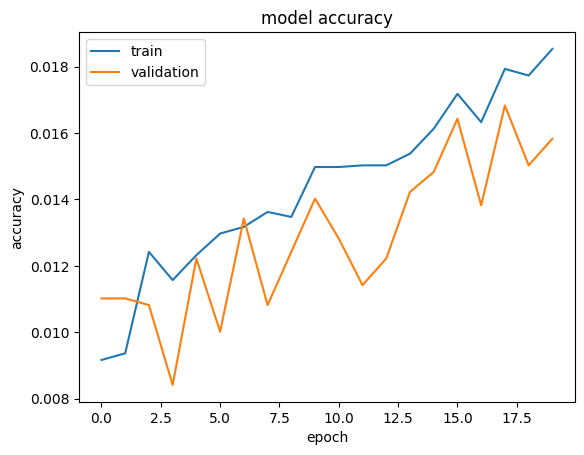

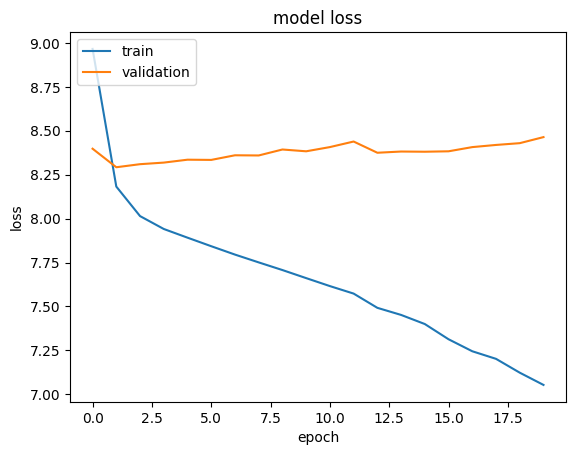

In [29]:
plot_training(history)

In [30]:
def summarize(article):
    # Reshape article to match model input shape
    article = np.reshape(article, (1, en_shape[0], en_shape[1]))  # Adjust dimensions if needed
    init_state_val = encoder.predict(article)  # Get initial states from encoder
    target_seq = np.zeros((1, 1, de_shape[1]))  # Initial target sequence (one-hot encoded for first token)
    generated_summary = []

    stop_pred = False
    max_length = 50  # Set an appropriate maximum length for the summary
    end_token_index = 1  # Set the index for the end token (e.g., '<eos>')

    while not stop_pred:
        # Predict the next token and new states
        decoder_out, decoder_h, decoder_c = decoder.predict([target_seq] + init_state_val)

        # Append the prediction to the summary
        generated_summary.append(decoder_out[0, 0, :])  # Ensure correct indexing
        
        # Update the states
        init_state_val = [decoder_h, decoder_c]
        
        # Prepare the next target sequence
        token_index = np.argmax(decoder_out[0, 0, :])  # Get index of the highest probability token
        target_seq = np.zeros((1, 1, de_shape[1]))  # Initialize new target sequence
        target_seq[0, 0, token_index] = 1  # One-hot encode the predicted token
        
        # Stop if the sequence is too long or if the end token is predicted
        if len(generated_summary) >= max_length or token_index == end_token_index:
            stop_pred = True

    # Convert generated summary to text
    generated_summary = np.array(generated_summary)
    summary_text = generateText(generated_summary)
    return summary_text

In [31]:
def generateText(SentOfVecs):
    # Assumes SentOfVecs is a numpy array of token indices
    SentOfVecs = np.reshape(SentOfVecs, (-1,))
    summary = ' '.join([label_encoder.inverse_transform([index])[0] for index in SentOfVecs])
    return summary

# Example usage
article_index = 8  # Index for the article you want to summarize

# Generate summary
generated_summary = summarize(train_data["article"][article_index])

# Print generated summary and references
print("Generated Summary:")
print(generateText(generated_summary))
print("\nOriginal Abstract:")
print(data["abstract"][article_index])
print("\nOriginal Article:")
print(data["articles"][article_index])

1/1 [==============================] - 1s 624ms/step


ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_2' (type Functional).
    
    Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 600, but received input with shape (None, 1, 300)
    
    Call arguments received by layer 'model_2' (type Functional):
      • inputs=('tf.Tensor(shape=(None, 1, 15149), dtype=float32)', 'tf.Tensor(shape=(None, 300), dtype=float32)', 'tf.Tensor(shape=(None, 300), dtype=float32)')
      • training=False
      • mask=None


In [ ]:
print(data.head())

In [ ]:
print(generateText(summarize(train_data["article"][8])))
print(data["abstract"][8])
#print(data["articles"][78])

In [ ]:
"""def wordvecmatrix(model,data):
    IO_data={"article":[],"abstract":[]}
    i=1
    for k in range(len(data["article"])):
        art=[]
        summ=[]
        for word in wt(data["article"][k].lower()):
            try:
                art.append(model.wv.word_vec(word))
            except Exception as e:
                print(e)

        for word in wt(data["abstract"][k].lower()):
            try:
                summ.append(onehot[word])
                #summ.append(model.wv.word_vec(word))
            except Exception as e:
                print(e)
        
        IO_data["article"].append(art) 
        IO_data["abstract"].append(summ)
        if i%100==0:
            print("progress: " + str(((i*100)/len(data["article"]))))
        i+=1
    #announcedone()
    print('\007')
    return IO_data"""

In [ ]:
"""def encoder_decoder(data):
    print('Encoder_Decoder LSTM')
   
    # encoder
    encoder_inputs = Input(shape=en_shape)
    
    encoder_LSTM = LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True)
    encoder_LSTM_rev = LSTM(hidden_units, return_state=True, return_sequences=True, dropout=0.05, recurrent_dropout=0.05, go_backwards=True)

    encoder_outputs, state_h, state_c = encoder_LSTM(encoder_inputs)
    encoder_outputsR, state_hR, state_cR = encoder_LSTM_rev(encoder_inputs)
    
    state_hfinal=Add()([state_h,state_hR])
    state_cfinal=Add()([state_c,state_cR])
    encoder_outputs_final = Add()([encoder_outputs,encoder_outputsR])
    
    encoder_states = [state_hfinal,state_cfinal]
    
    # decoder
    decoder_inputs = Input(shape=(None,de_shape[1]))
    decoder_LSTM = LSTM(hidden_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, return_state=True)
    decoder_outputs, _, _ = decoder_LSTM(decoder_inputs,initial_state=encoder_states)
    
    # Pull out XGBoost, (I mean attention)
    attention = TimeDistributed(Dense(1, activation = 'tanh'))(encoder_outputs_final)
    attention = Flatten()(attention)
    attention = Multiply()([decoder_outputs, attention])
    attention = Activation('softmax')(attention)
    attention = Permute([2, 1])(attention)
 
    decoder_dense = Dense(de_shape[1],activation='softmax')
    decoder_outputs = decoder_dense(attention)
    
    model= Model(inputs=[encoder_inputs,decoder_inputs], outputs=decoder_outputs)
    print(model.summary())
    
    rmsprop = RMSprop(lr=learning_rate,clipnorm=clip_norm)
    model.compile(loss='categorical_crossentropy',optimizer=rmsprop,metrics=['accuracy'])
    
    x_train,x_test,y_train,y_test=tts(data["article"],data["abstract"],test_size=0.20)
    
    history= model.fit(x=[x_train,y_train],
              y=y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=([x_test,y_test], y_test))
    print(model.summary())
    
    # inference mode
    encoder_model_inf = Model(encoder_inputs,encoder_states)
    
    decoder_state_input_H = Input(shape=(en_shape[0],))
    decoder_state_input_C = Input(shape=(en_shape[0],)) 
    decoder_state_inputs = [decoder_state_input_H, decoder_state_input_C]
    decoder_outputs, decoder_state_h, decoder_state_c = decoder_LSTM(decoder_inputs,
                                                                     initial_state=decoder_state_inputs)
    decoder_states = [decoder_state_h, decoder_state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    
    decoder_model_inf= Model([decoder_inputs]+decoder_state_inputs,
                         [decoder_outputs]+decoder_states)
    
    scores = model.evaluate([x_test,y_test],y_test, verbose=1)
    
    
    print('LSTM test scores:', scores)
    print('\007')
    print(model.summary())
    return model,encoder_model_inf,decoder_model_inf,history"""

In [ ]:
"""def generateText(SentOfVecs):
    SentOfVecs=np.reshape(SentOfVecs,de_shape)
    kk=""
    for k in SentOfVecs:
        kk = kk + label_encoder.inverse_transform([argmax(k)])[0].strip()+" "
        #kk=kk+((getWord(k)[0]+" ") if getWord(k)[1]>0.01 else "")
    return kk"""

In [ ]:
""""def summarize(article):
    stop_pred = False
    article =  np.reshape(article,(1,en_shape[0],en_shape[1]))
    #get initial h and c values from encoder
    init_state_val = encoder.predict(article)
    target_seq = np.zeros((1,1,de_shape[1]))
    #target_seq =np.reshape(train_data['summaries'][k][0],(1,1,de_shape[1]))
    generated_summary=[]
    while not stop_pred:
        decoder_out,decoder_h,decoder_c= decoder.predict(x=[target_seq]+init_state_val)
        generated_summary.append(decoder_out)
        init_state_val= [decoder_h,decoder_c]
        #get most similar word and put in line to be input in next timestep
        #target_seq=np.reshape(model.wv[getWord(decoder_out)[0]],(1,1,emb_size_all))
        target_seq=np.reshape(decoder_out,(1,1,de_shape[1]))
        if len(generated_summary)== de_shape[0]:
            stop_pred=True
            break
    return generated_summary"""

In [ ]:
"""def evaluate_summ(article):
    ref=''
    for k in wt(data['abstract'][article])[:20]:
        ref=ref+' '+k
    gen_sum = generateText(summarize(train_data["article"][article]))
    print("-----------------------------------------------------")
    print("Original summary")
    print(ref)
    print("-----------------------------------------------------")
    print("Generated summary")
    print(gen_sum)
    print("-----------------------------------------------------")
    rouge = Rouge155()
    score = rouge.score_summary(ref, gen_sum)
    print("Rouge1 Score: ",score)"""

In [ ]:
"""def generateText(SentOfVecs):
    kk = ""
    for k in SentOfVecs[0]:  # Adjust indexing if needed
        kk += label_encoder.inverse_transform([np.argmax(k)])[0].strip() + " "
    return kk"""